# Проект для «Викишоп» c BERT 


**Описание исседования** <br>

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.
Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.
Постройте модель со значением метрики качества F1 не меньше 0.75.

**Описание данных**

Столбец text в нём содержит текст комментария, а toxic — целевой признак.

**Содержание**

 [Шаг 1. Загрузка и подготовка данных](#step1)
 
 [Шаг 2. Обучение моделей](#step2)
 
 [Шаг 3. Тестирование моделей](#step3)
 
 [Шаг 4. BERT](#step4)
 
 [Шаг 5. Общий вывод](#step5)

<a id = 'step1'></a>
# Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
import re
import os
import spacy
import warnings
from tqdm.notebook import tqdm

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, roc_curve
from sklearn.utils import shuffle

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

import torch
import transformers as ppb 
from tqdm import notebook

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anastasiabukatkina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/anastasiabukatkina/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/anastasiabukatkina/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# !{sys.executable} -m pip install spacy
# !{sys.executable} -m spacy download en

In [3]:
# !pip3 install --upgrade pip

In [4]:
# !pip install -U spacy==2.1.3

In [5]:
if os.path.exists('toxic_comments.csv'):
    data = pd.read_csv('toxic_comments.csv') #локальный путь
else:
    data = pd.read_csv('toxic_comments.csv') #путь, указанный в проекте

In [6]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
data.shape

(159571, 2)

In [8]:
print("20 :", data.loc[20,'text'])
print('------------------------------')
print("\n100 :", data.loc[100,'text'])
print('------------------------------')
print("\n1000 :", data.loc[1500,'text'])

20 : "

 Regarding your recent edits 

Once again, please read WP:FILMPLOT before editing any more film articles.  Your edits are simply not good, with entirely too many unnecessary details and very bad writing.  Please stop before you do further damage. -''''''The '45 "
------------------------------

100 : However, the Moonlite edit noted by golden daph was me (on optus ...)  Wake up wikkis.  So funny
------------------------------

1000 : There is no evidence that this block has anything to do with sock accounts. My use of my accounts was completely legitimate. And contrary to what Rodhullandemu is trying to imply, the only accounts that I used in the police talk page are mr3003nights and this one (which is a completely legitimate practice). I was blocked for a discussion in the talk page of the article on the policenot for editing the actual article. Please read that discussion I linked to and see it for yourself that it was pure unjustified retaliation for offering evidence Rodhul

0    0.898321
1    0.101679
Name: toxic, dtype: float64


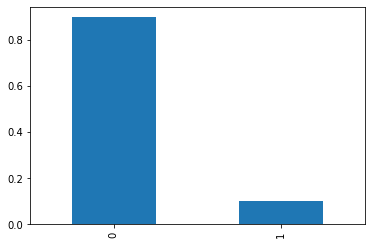

In [9]:
class_frequency = data['toxic'].value_counts(normalize = True)
print(class_frequency)
class_frequency.plot(kind = 'bar')
plt.show()

In [10]:
data.duplicated().sum()


0

In [11]:
data.isna().sum()

text     0
toxic    0
dtype: int64

In [12]:
#работает, но очень долго

# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# # sentence = "The striped bats are hanging on their feet for best"
# # doc = nlp(sentence)
# def clear_and_lemmatize(text):
#     text = text.lower()
#     clear_text = re.sub(r'[^a-zA-Z]', ' ', text)
#     clear_text =  clear_text.split()
#     clear_text = " ".join(clear_text)
#     lemm_list = nlp(clear_text)
#     lemm_text = " ".join([token.lemma_ for token in lemm_list])
        
#     return lemm_text

In [13]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    text = text.lower()
    clear_text = re.sub(r'[^a-zA-Z]', ' ', text)
    clear_text =  clear_text.split()
    clear_text = " ".join(clear_text)
    lemm_text = " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(clear_text)])
    return lemm_text

In [14]:
%%time
data['clear_and_lemm'] = data['text'].apply(lemmatize)

CPU times: user 8min 3s, sys: 37.8 s, total: 8min 41s
Wall time: 8min 44s


In [15]:
data.head()

,text,toxic,clear_and_lemm
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


<div class="alert alert-block alert-info">
    
**Комментарий студента** 
    
В данных нет пропусков или дубликатов, но классы несбалансированы. 

Подготовим признаки и целевой признак перед обучением.

<a id = 'step2'></a>
# Обучение

In [16]:
X_train, X_temp, y_train, y_temp = train_test_split(data['clear_and_lemm'], data['toxic'], test_size=0.4, random_state=123)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)


In [17]:
#функция для балансировки классов

# def upsample(features, target, repeat):
#     features_zeros = features[target == 0]
#     features_ones = features[target == 1]
#     target_zeros = target[target == 0]
#     target_ones = target[target == 1]

#     features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
#     target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
#     features_upsampled, target_upsampled = shuffle(
#         features_upsampled, target_upsampled, random_state=12345)
    
#     return features_upsampled, target_upsampled


In [18]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled


<a id = 'step3_2'></a>
<font color='black' size = +1><b> Мешок слов</b></font><br>

In [19]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_vect = CountVectorizer(stop_words=stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anastasiabukatkina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
n_gramm_train = count_vect.fit_transform(X_train)
n_gramm_valid = count_vect.transform(X_valid)
n_gramm_test = count_vect.transform(X_test)
print("Размер train'a:", n_gramm_train.shape)
print("Размер valid'a:", n_gramm_valid.shape)
print("Размер test'a:", n_gramm_test.shape)

Размер train'a: (95742, 111132)
Размер valid'a: (31914, 111132)
Размер test'a: (31915, 111132)


In [21]:
model_lr = LogisticRegression(max_iter=1000, random_state=123)
model_lr.fit(n_gramm_train, y_train)
print("train:", model_lr.score(n_gramm_train, y_train))
print("valid:", model_lr.score(n_gramm_valid, y_valid))
print("\nF1 valid: {:.4f}".format(f1_score(y_valid, model_lr.predict(n_gramm_valid))))

train: 0.9791523051534332
valid: 0.9551294102901547

F1 valid: 0.7524


In [22]:
fpr, tpr, thresholds = roc_curve(y_valid, model_lr.predict_proba(n_gramm_valid)[:,1])

**UPsampling**

In [23]:
# features_upsampled, target_upsampled = upsample(X_train, y_train, 10)

In [24]:
# n_gramm_train_upsampled = count_vect.fit_transform(features_upsampled)
# n_gramm_test_upsampled = count_vect.transform(X_test)
# print("Размер train'a:", n_gramm_train_upsampled.shape)
# print("Размер test'a:", n_gramm_test_upsampled.shape)

In [25]:
# model_up = LogisticRegression(max_iter=2000, random_state=123)
# model_up.fit(n_gramm_train_upsampled, target_upsampled)
# print("train:", model_up.score(n_gramm_train_upsampled, target_upsampled))
# print("test:", model_up.score(n_gramm_test_upsampled, y_test))


# print("\nF1: {:.4f}".format(f1_score(y_test, model_up.predict(n_gramm_test_upsampled))))

In [26]:
# fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, model_up.predict_proba(n_gramm_test_upsampled)[:,1])

**Downsampling**

In [27]:
features_down, target_down = downsample(X_train, y_train, 0.12)

In [28]:
n_gramm_train_down = count_vect.fit_transform(features_down)
n_gramm_valid_down = count_vect.transform(X_valid)
n_gramm_valid_test = count_vect.transform(X_test)
print("Размер train'a:", n_gramm_train_down.shape)
print("Размер valid'a:", n_gramm_valid_down.shape)

Размер train'a: (20150, 39847)
Размер valid'a: (31914, 39847)


In [29]:
model_down = LogisticRegression(max_iter=1000, random_state=123)
model_down.fit(n_gramm_train_down, target_down)
print("train:", model_down.score(n_gramm_train_down, target_down))
print("valid:", model_down.score(n_gramm_valid_down, y_valid))


print("\nF1 valid: {:.4f}".format(f1_score(y_valid, model_down.predict(n_gramm_valid_down))))

train: 0.9806451612903225
valid: 0.9160556495581876

F1 valid: 0.6729


In [30]:
fpr_1, tpr_1, thresholds_1 = roc_curve(y_valid, model_down.predict_proba(n_gramm_valid_down)[:,1])

**SGDClassifier**

In [31]:
kf = KFold(n_splits=3, shuffle=True, random_state=123)
classificator = SGDClassifier()
hyperparams = [{'loss':['log', 'modified_huber'],
                'learning_rate':['constant', 'adaptive'],
                'eta0':[0.1, 0.2, 0.3],
                'random_state':[123]}]


clf = GridSearchCV(classificator, hyperparams, scoring='f1', cv=kf, n_jobs=-1)
clf.fit(n_gramm_train, y_train)

SGDC_best_params = clf.best_params_

In [32]:
classificator = SGDClassifier()
classificator.set_params(**SGDC_best_params)
classificator.fit(n_gramm_train, y_train)
predict = classificator.predict(n_gramm_valid)
f1_SGDC = f1_score(y_valid, predict)

print('F1:{:.4f} valid'.format(f1_SGDC))

F1:0.7529 valid


In [33]:
fpr_2, tpr_2, thresholds_2 = roc_curve(y_valid, classificator.predict_proba(n_gramm_valid)[:,1])

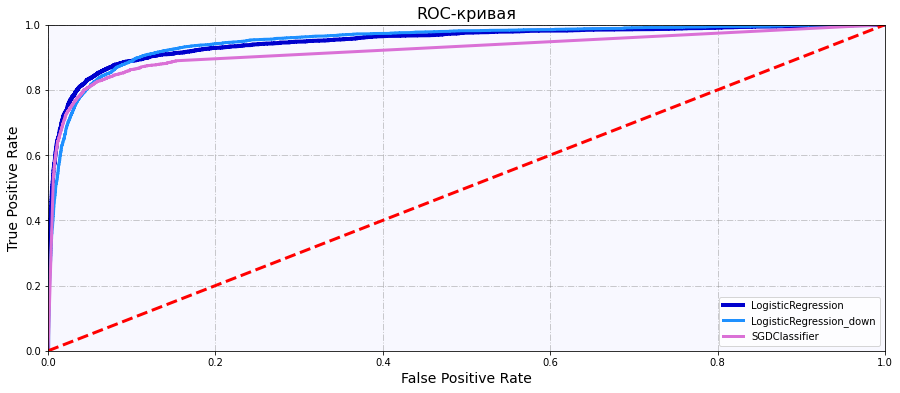

In [34]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(fpr, tpr, linewidth=4, color='mediumblue')
ax.plot(fpr_1, tpr_1, linewidth=3, color='dodgerblue')
ax.plot(fpr_2, tpr_2, linewidth=3, color='orchid')
#ax.plot(fpr_3, tpr_3, linewidth=2, color='lawngreen')
ax.legend(['LogisticRegression','LogisticRegression_down','SGDClassifier'])

ax.plot([0, 1], [0, 1], linestyle='--', linewidth=3, color = 'r')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate',fontsize=14)
ax.set_ylabel('True Positive Rate',fontsize=14)
ax.set_title('ROC-кривая',fontsize=16)

ax.grid(color ='grey',
        linestyle ='-.', linewidth = 1,
        alpha = 0.4)
ax.set_facecolor('ghostwhite')

**TF-IDF**

**Балансируем по весу**

In [35]:
Tf_Idf_count = TfidfVectorizer(stop_words=stopwords)
n_gramm_train_tfidf = Tf_Idf_count.fit_transform(X_train)
n_gramm_valid_tfidf = Tf_Idf_count.transform(X_valid)
n_gramm_test_tfidf = Tf_Idf_count.transform(X_test)
print("Размер train'a:", n_gramm_train_tfidf.shape)
print("Размер valid'a:", n_gramm_valid_tfidf.shape)

Размер train'a: (95742, 111132)
Размер valid'a: (31914, 111132)


In [36]:
model_lr_tfidf = LogisticRegression(max_iter=2000, class_weight = 'balanced', random_state=123)
model_lr_tfidf.fit(n_gramm_train_tfidf, y_train)
print("train:", model_lr_tfidf.score(n_gramm_train_tfidf, y_train))
print("valid:", model_lr_tfidf.score(n_gramm_valid_tfidf, y_valid))

print("\nF1 valid: {:.4f}".format(f1_score(y_valid, model_lr_tfidf.predict(n_gramm_valid_tfidf))))

train: 0.9592655261013975
valid: 0.9396503102086858

F1 valid: 0.7374


In [37]:
fpr, tpr, thresholds = roc_curve(y_valid, model_lr_tfidf.predict_proba(n_gramm_valid_tfidf)[:,1])

**UPsampling**

In [38]:
# n_gramm_train_upsampled = Tf_Idf_count.fit_transform(features_upsampled)
# n_gramm_test_upsampled = Tf_Idf_count.transform(X_test)

# print("Размер train'a:", n_gramm_train_upsampled.shape)
# print("Размер test'a:", n_gramm_test_upsampled.shape)

In [39]:
# LR_up = LogisticRegression(max_iter=2000, random_state=123)
# LR_up.fit(n_gramm_train_upsampled, target_upsampled)
# print("train:", LR_up.score(n_gramm_train_upsampled, target_upsampled))
# print("test:", LR_up.score(n_gramm_test_upsampled, y_test))

# print("\nF1: {:.4f}".format(f1_score(y_test, LR_up.predict(n_gramm_test_upsampled))))

In [40]:
# fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, classificator.predict_proba(n_gramm_test_upsampled)[:,1])

**Downsampling**

In [41]:
n_gramm_train_down_tfidf = Tf_Idf_count.fit_transform(features_down)
n_gramm_valid_down_tfidf = Tf_Idf_count.transform(X_valid)
n_gramm_test_down_tfidf = Tf_Idf_count.transform(X_test)
print("Размер train'a:", n_gramm_train_down_tfidf.shape)
print("Размер test'a:", n_gramm_valid_down_tfidf.shape)

Размер train'a: (20150, 39847)
Размер test'a: (31914, 39847)


In [42]:
model_down_tfidf = LogisticRegression(max_iter=1000, random_state=123, class_weight = 'balanced')
model_down_tfidf.fit(n_gramm_train_down_tfidf, target_down)
print("train:", model_down.score(n_gramm_train_down_tfidf, target_down))
print("valid:", model_down.score(n_gramm_valid_down_tfidf, y_valid))


print("\nF1 valid: {:.4f}".format(f1_score(y_valid, model_down.predict(n_gramm_valid_down_tfidf))))

train: 0.8347890818858561
valid: 0.953406028702137

F1 valid: 0.7355


**SGDClassifier**

In [43]:
kf = KFold(n_splits=3, shuffle=True, random_state=123)
classificator_tfidf = SGDClassifier()
hyperparams = [{'loss':['log', 'modified_huber'],
                'learning_rate':['constant', 'adaptive'],
                'eta0':[0.1, 0.2, 0.3],
                'random_state':[123],
                'class_weight':['balanced']}]


clf = GridSearchCV(classificator_tfidf, hyperparams, scoring='f1', cv=kf, n_jobs=-1)
clf.fit(n_gramm_train_tfidf, y_train)

SGDC_best_params = clf.best_params_

In [44]:
classificator_tfidf = SGDClassifier()
classificator_tfidf.set_params(**SGDC_best_params)
classificator_tfidf.fit(n_gramm_train_tfidf, y_train)
predict = classificator_tfidf.predict(n_gramm_valid_tfidf)
f1_SGDC = f1_score(y_valid, predict)

print('F1: {:.4f} valid'.format(f1_SGDC))

F1: 0.7417 valid


In [45]:
fpr_2, tpr_2, thresholds_2 = roc_curve(y_valid, classificator_tfidf.predict_proba(n_gramm_valid_tfidf)[:,1])

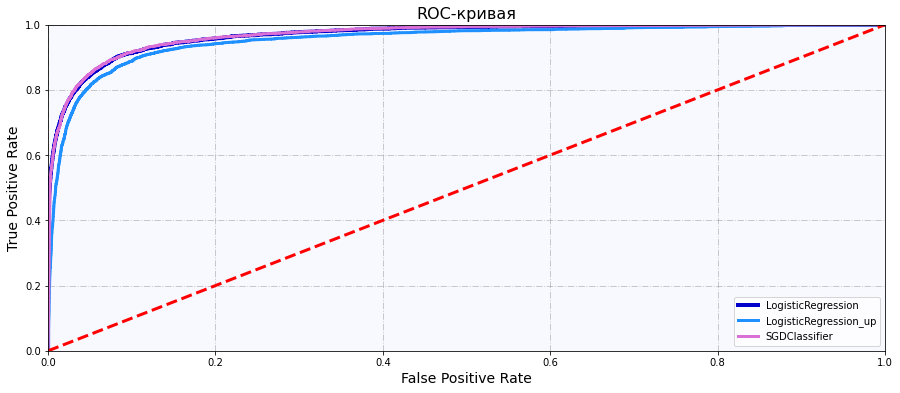

In [46]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(fpr, tpr, linewidth=4, color='mediumblue')
ax.plot(fpr_1, tpr_1, linewidth=3, color='dodgerblue')
ax.plot(fpr_2, tpr_2, linewidth=3, color='orchid')
#ax.plot(fpr_3, tpr_3, linewidth=2, color='lawngreen')
ax.legend(['LogisticRegression','LogisticRegression_up','SGDClassifier'])

ax.plot([0, 1], [0, 1], linestyle='--', linewidth=3, color = 'r')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate',fontsize=14)
ax.set_ylabel('True Positive Rate',fontsize=14)
ax.set_title('ROC-кривая',fontsize=16)

ax.grid(color ='grey',
        linestyle ='-.', linewidth = 1,
        alpha = 0.4)
ax.set_facecolor('ghostwhite')

<div class="alert alert-block alert-info">
    
**Комментарий студента** 

На валидационной выборке порог по метрике F1 прошли модель логистической регресси и стохастический градиентный спуск с балансировкой классов по весу. В обоих случаях векторизация - "Bag of words". Балансировка классов с помошью Downsampling к улучшению результата не приводит. 

<a id = 'step3'></a>
# Тестирование

In [47]:
print("Logistic Regression F1 test: {:.4f}".format(f1_score(y_test, model_lr.predict(n_gramm_test))))
print()
print('SGDClassifier F1 test: {:.4f} '.format(f1_score(y_test, classificator.predict(n_gramm_test))))

Logistic Regression F1 test: 0.7592

SGDClassifier F1 test: 0.7645 


<a id = 'step4'></a>
# BERT

**Здесь мы просто знакомимся с Bert. Воcпользуемся нашими данными, но создадим хорошиее условия для задачи - сбалансируем классы**

In [48]:
if os.path.exists('toxic_comments.csv'):
    df = pd.read_csv('toxic_comments.csv') 
else:
    df = pd.read_csv('toxic_comments.csv')
    

In [49]:
df_0 = df[df['toxic']==0].sample(400, random_state=123).reset_index(drop=True)

In [50]:
df_1 = df[df['toxic']==1].sample(400, random_state=123).reset_index(drop=True)

In [51]:
df = pd.concat([df_0, df_1]).sample(frac=1, random_state=123)
df

,text,toxic
145,"""\nAgain, Paul Brass is the foremost political...",0
171,Fuck you \n\nYou should be ashamed of yourself...,1
229,I did not know that...,0
202,Jungle Fight \nAbout your comments:\n01. They ...,0
185,"""\n\n""""I resigned because I was the subject of...",0
...,...,...
98,"""\n\n Hello! \n\nPlease, tell me where is my h...",0
322,"""\n\n GA Review II \n\nI'm sorry to say this, ...",0
382,admin \n\nok i will search for an admin. you d...,0
365,Cary Grant\n\nWhat are you talking about? cary...,0


In [52]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Загрузка предобученной модели/токенизатора 
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [53]:
#токенизируем текст
tokenized = df['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True)))

In [54]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [55]:
batch_size = 100
embeddings = []
for i in tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/8 [00:00<?, ?it/s]

In [56]:
features = np.concatenate(embeddings)

In [57]:
warnings.filterwarnings("ignore")

target = df['toxic']
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                    test_size=0.5, random_state=123)

model = LogisticRegression(random_state=123)
model.fit(X_train,y_train)
print('F1 score BERT+LogisticRegression: {:.4f}'.format(cross_val_score(model, X_train, y_train, scoring="f1").mean()))


F1 score BERT+LogisticRegression: 0.8410


<a id = 'step5'></a>

    
<h2> Общий вывод <a class="tocSkip"></h2>
    
В данной работе мы должны были проанализироать комментарии, предоставленные интернет-магазином «Викишоп», и построить модель, которая должна классифицировать эти комментарий как позитивные и негативные. 
    
Данные не требовали дополнительной предобработки, кроме лемматизации и о очистки от символов, отличных от латиницы. 
На этапе анализа мы обнаружили, что классы не сбалансированы. Поэтому пробовали обучать различные модели на исходных данных и на уменьшенной выборке, применив метод downsampling. При переводе текстов в векторный формат мы использовали два метода - "Мешок слов" и "TF-IDF"
   
Среди моделей, которые мы обучали были логистическая регрессия и стохастический градиентный спуск. Лучше всего на валидационной выборке себя показала модель стохастического градиентного спуска, с применением векторизации "Мешок слов" - F1 = 0.7529. В целом, логистическая регрессия показала почти такой же результат - F1 = 0.7524. 
   
На тестовой выборке разница заметна уже чуть больше: 
* Logistic Regression - F1 = 0.7592
* SGDClassifier - F1 = 0.7645
    
    
При использовании векторизации "TF-IDF" снова лучше всего отработала модель SGDClassifier - F1 = 0.7417, но это не удовлетворяет условиям задачи. 
   
    
Лучше всего, ожидаемо, отработала модель логистической регрессии, на вход которой подаются предложения, обработанные спомошью BERT: F1 = 0.8410. Однако, это результат на выборке, которую пришлось уменьшить в 150 раз, чтобы дождаться результата, к тому же мы сбалансировали классы. 
</div> 